Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Extract interface node from sub_2 and sub_1
Interface nodes from sub_1 and sub_2 already extracted


<IPython.core.display.Javascript object>


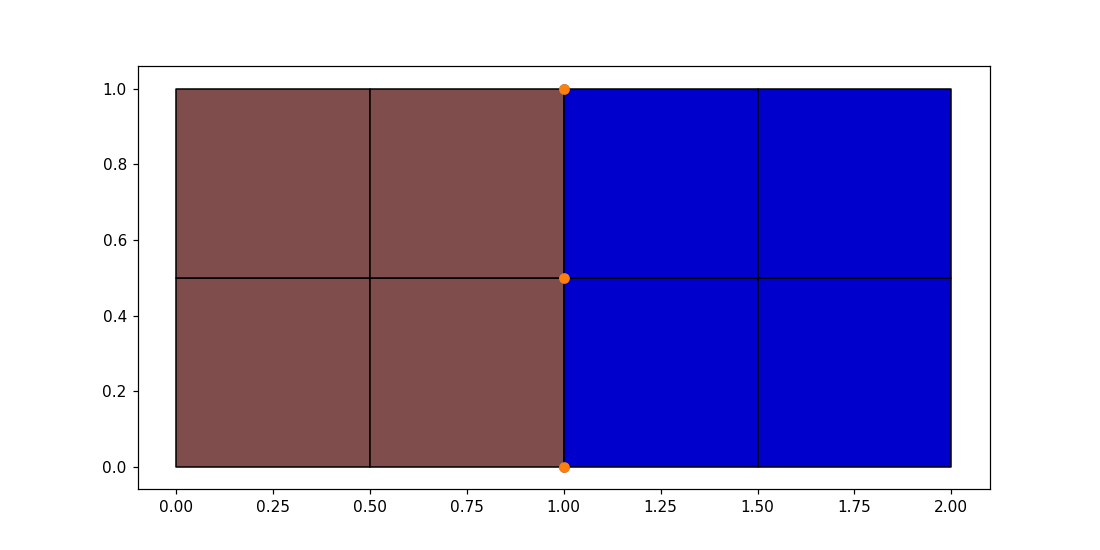

In [1]:
%matplotlib notebook
import sys 
import pandas as pd
#sys.path.append('H:\TUM-PC\Dokumente\Projects\AMfe')

import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy

msh_dict = {}
msh_dict[1] = mshfile = amfe.amfe_dir('meshes/test_meshes/geo_hole_quad_part_4.msh')
msh_dict[2] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_quad_mesh.msh')
msh_dict[3] = mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_2quad_mesh.msh')
msh_dict[4] = mshfile = amfe.amfe_dir('meshes/test_meshes/4_partitions_quad_mesh.msh')


domain_id = {}
domain_id[1] = 8
domain_id[2] = 3
domain_id[3] = 3
domain_id[4] = 3

# select mesh to be plotted
mesh_id = 2
mshfile = msh_dict[mesh_id]

m = amfe.Mesh()
m.import_msh(mshfile)


# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)


# splitting physical grops

m.split_in_groups()

# plotting boundary elements
#amfe.plot_boundary_1d(m)


# plotting mesh
#amfe.plot_submesh(m.groups[domain_id[mesh_id]])


# setting boundary condition
# selecting subdomain for boundary condition
sub_dir = m.get_submesh('phys_group',1)
sub_neu = m.get_submesh('phys_group',2)

value = 5.0E9
neu = amfe.boundary.Boundary(sub_neu,value,'normal')
diri = amfe.boundary.Boundary(sub_dir,0,'xy','dirichlet')


# setting main domain for FE calculation
domain = m.set_domain('phys_group', domain_id[mesh_id])
domain.set_material(my_material)
domain.append_bondary_condition(neu)
domain.append_bondary_condition(diri)
domain.split_in_partitions()

fig, ax10 = plt.subplots(figsize=(10,5))
amfe.plot_domain(domain,ax=ax10)

plt.show()


In [22]:
plt.savefig('mesh.png')

In [2]:
scale = 1
my_system = amfe.MechanicalSystem()
my_system.set_mesh_obj(m)
my_system.set_domain(domain_id[mesh_id],my_material)
my_system.apply_dirichlet_boundaries(1, 'xy')
my_system.apply_neumann_boundaries(2, value, 'normal')

K_global = my_system.assembly_class.assemble_k_and_f()

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 8 elements and 30 dofs.
Time taken for preallocation: 0.00 seconds.


In [3]:
# creating a dataframe based on id_matrix node, direction -> dof
id_matrix = my_system.assembly_class.id_matrix
id_map_df = pd.DataFrame.from_dict(id_matrix, columns=['x','y'],orient='index')

In [4]:
id_map_df



,x,y
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
5,10,11
6,12,13
7,14,15
8,16,17
9,18,19


In [5]:
list(id_map_df['x'][[0,1,2]])

[0, 2, 4]

In [6]:
g1 = m.groups[1] # Dirichlet
g2 = m.groups[2] # Neumann 
g3 = m.groups[3] # Domain

In [7]:
g1.global_node_list

[0, 11, 3]

In [8]:
g2.global_node_list

[1, 2, 7]

In [9]:
g3.global_node_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [10]:
sys.path.insert(0,'..')
from pyfeti.src.utils import OrderedSet, Get_dofs, save_object
import collections

gdof = Get_dofs(id_map_df)

dir_dofs = gdof.get(g1.global_node_list,'xy')
neu_dofs_y = gdof.get(g2.global_node_list,'y')
neu_dofs_x = gdof.get(g2.global_node_list,'x')
all_dofs = gdof.get(g3.global_node_list,'xy')

dof_dict = collections.OrderedDict()
dof_dict['dirichlet'] = OrderedSet(dir_dofs)
dof_dict['neu_x'] = OrderedSet(neu_dofs_y)
dof_dict['neu_y'] = OrderedSet(neu_dofs_x)
dof_dict['internal'] = OrderedSet(all_dofs) - (dir_dofs+neu_dofs_y+neu_dofs_x)


save_object(dof_dict,'dofs_dict.pkl')


In [11]:
dof_dict

OrderedDict([('dirichlet', OrderedSet([0, 1, 6, 7, 22, 23])),
             ('neu_x', OrderedSet([3, 5, 15])),
             ('neu_y', OrderedSet([2, 4, 14])),
             ('internal',
              OrderedSet([8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29]))])

In [12]:
dir_dofs

[0, 1, 6, 7, 22, 23]

In [13]:
g1.global_node_list

[0, 11, 3]

In [14]:
gdof.id_map_df

,x,y
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
5,10,11
6,12,13
7,14,15
8,16,17
9,18,19


In [15]:
d1 = domain.groups[1]
d2 = domain.groups[2]

In [16]:
d1.global_to_local_dict
d2.global_to_local_dict


{}

In [17]:
super_domain = amfe.SuperDomain(domain.groups)

B = super_domain.assemble_global_B()
Kd, fd = super_domain.assemble_block_stiffness_and_force()
G, e = super_domain.assemble_global_G_and_e()



Preallocating the stiffness matrix
Done preallocating stiffness matrix with 4 elements and 18 dofs.
Time taken for preallocation: 0.00 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 4 elements and 18 dofs.
Time taken for preallocation: 0.00 seconds.


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [18]:
len(super_domain.K_list)

2

In [19]:
sub1 = super_domain.get_feti_subdomains(1)
sub2 = super_domain.get_feti_subdomains(2)
B1_dict = sub1.assemble_interface_boolean_matrix()
B2_dict = sub2.assemble_interface_boolean_matrix()
K1 = super_domain.K_list[0]
K2 = super_domain.K_list[1]


K1.shape

(18, 18)

In [20]:
K2.shape

(18, 18)

In [21]:
save_object(K1,'K1.pkl')
save_object(K2,'K2.pkl')
save_object(B1_dict,'B1_dict.pkl')
save_object(B2_dict,'B2_dict.pkl')
save_object(d1.global_to_local_dict,'global2local_1.pkl')
save_object(d2.global_to_local_dict,'global2local_2.pkl')